In [34]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.utils import to_categorical

In [2]:
train_df = pd.read_csv('../data/train.txt', sep=';', header=None, names=['text', 'emotion'])
test_df = pd.read_csv('../data/test.txt', sep=';', header=None, names=['text', 'emotion'])
val_df = pd.read_csv('../data/validation.txt', sep=';', header=None, names=['text', 'emotion'])

combined_df = pd.concat([train_df, test_df], ignore_index=True)

In [3]:
combined_df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
combined_df.shape

(18000, 2)

In [5]:
combined_df.isnull().sum()

text       0
emotion    0
dtype: int64

In [6]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     18000 non-null  object
 1   emotion  18000 non-null  object
dtypes: object(2)
memory usage: 281.4+ KB


In [7]:
combined_df.describe()

,text,emotion
count,18000,18000
unique,17958,6
top,i was so stubborn and that it took you getting...,joy
freq,2,6057


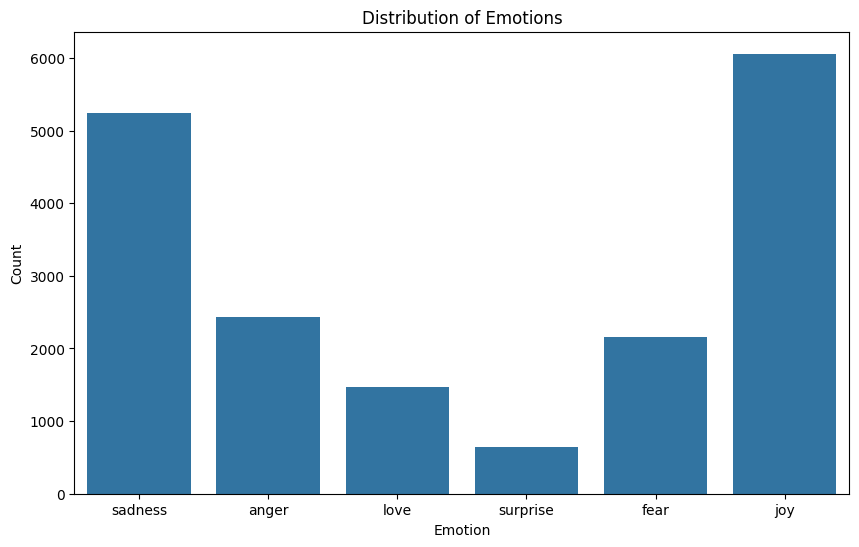

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=combined_df)
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [9]:
all_text = ' '.join(combined_df['text'])

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis', 
    max_words=50
).generate(all_text)

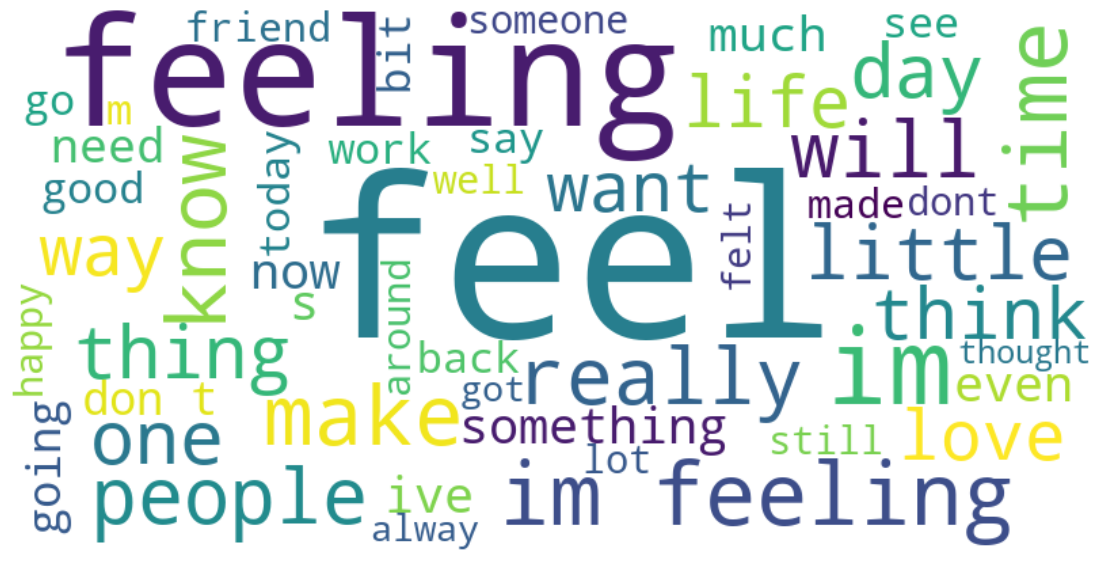

In [10]:
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Processing text

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [12]:
def clean_text(text):
    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

In [13]:
combined_df['clean_text'] = combined_df['text'].apply(clean_text)

In [14]:
combined_df.head()

,text,emotion,clean_text
0,i didnt feel humiliated,sadness,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,anger,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,anger,feeling grouchy


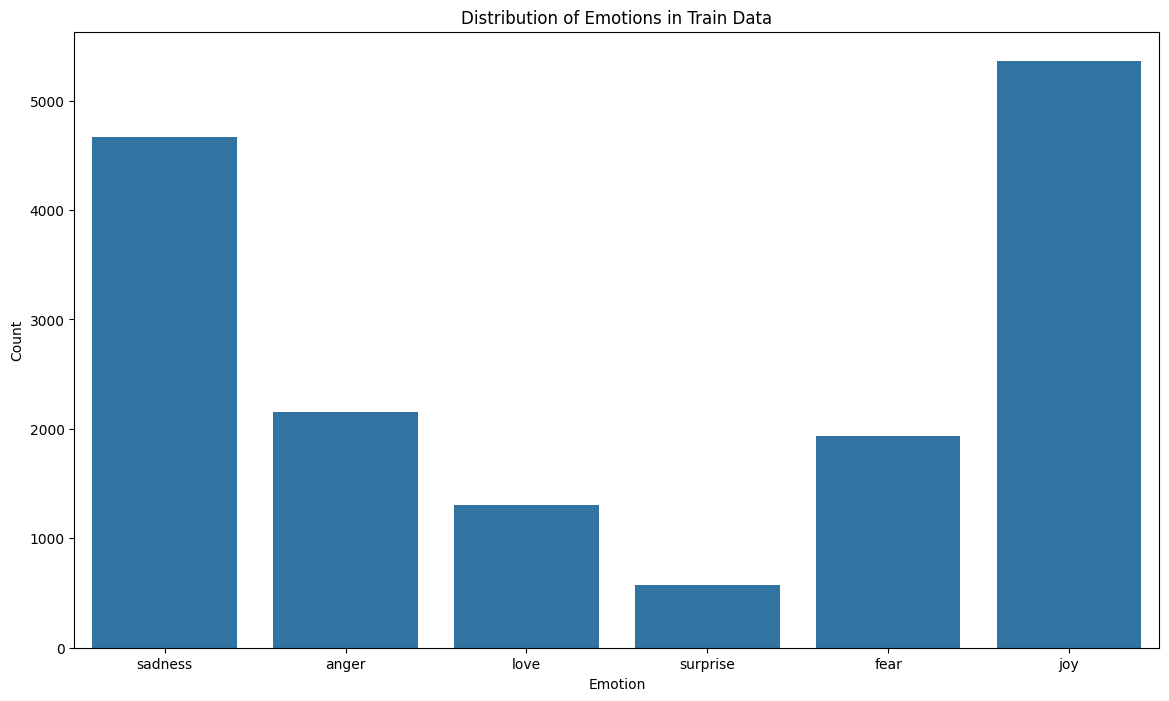

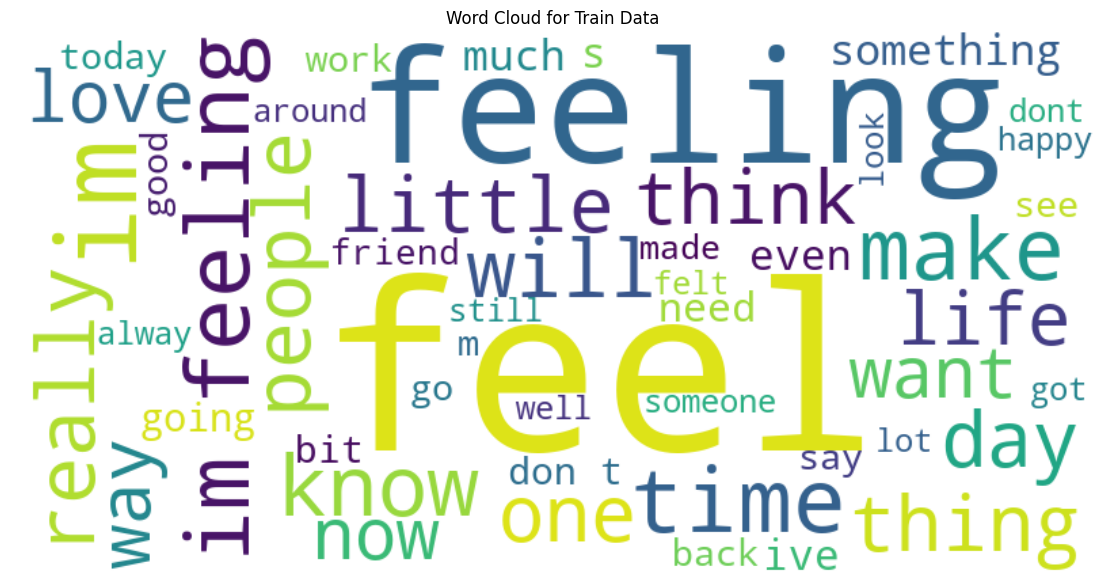

################################################################
################################################################


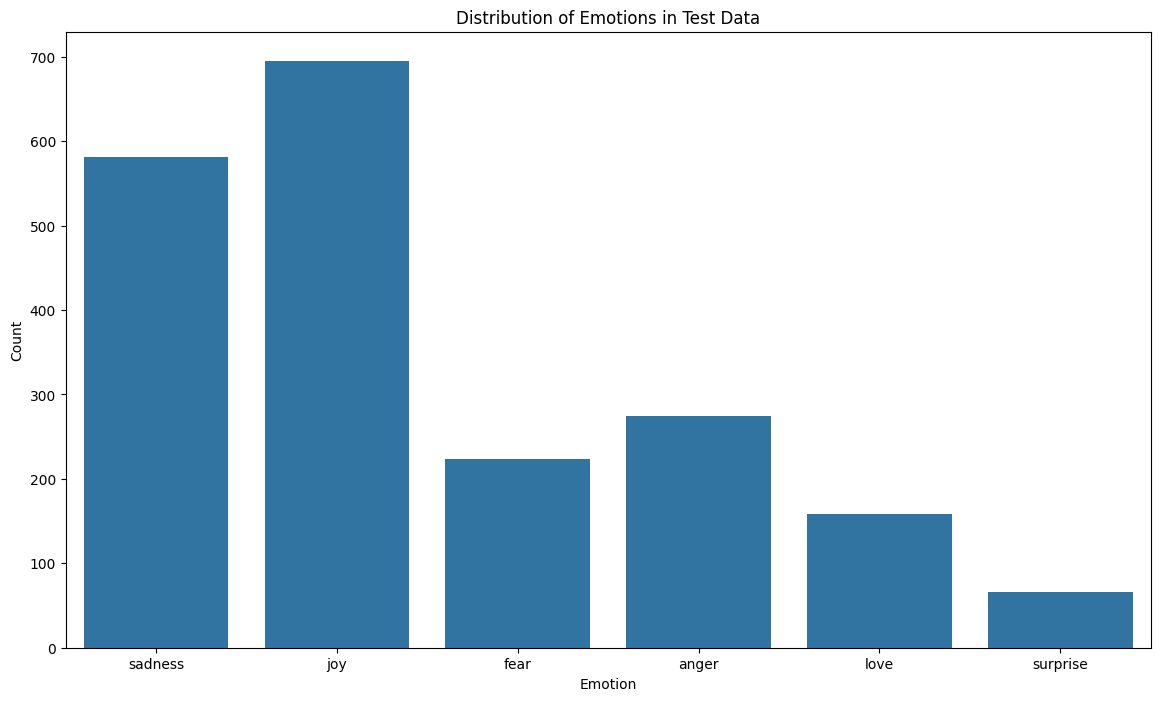

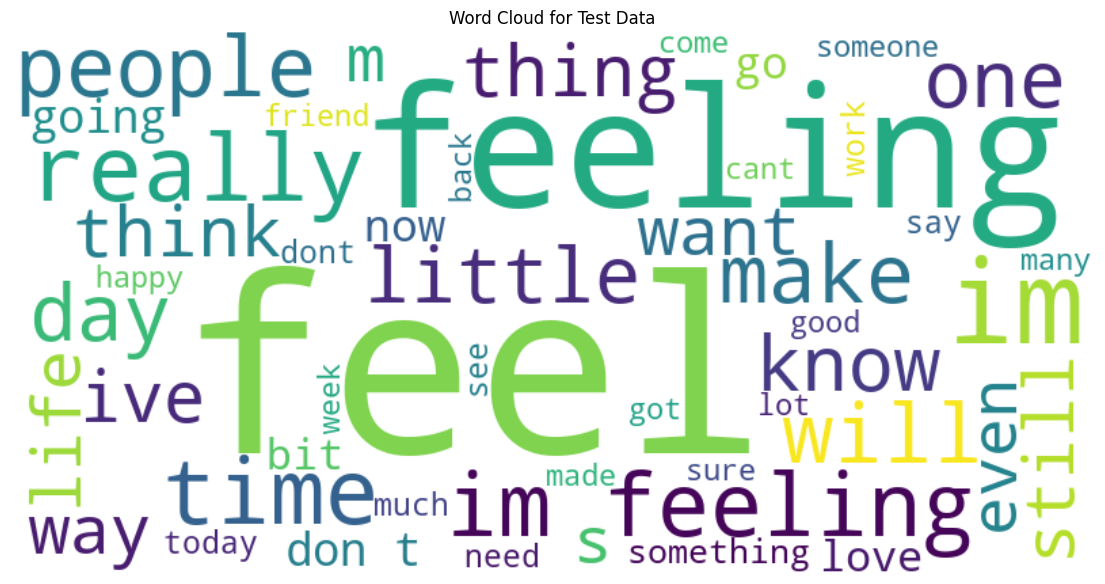

################################################################
################################################################


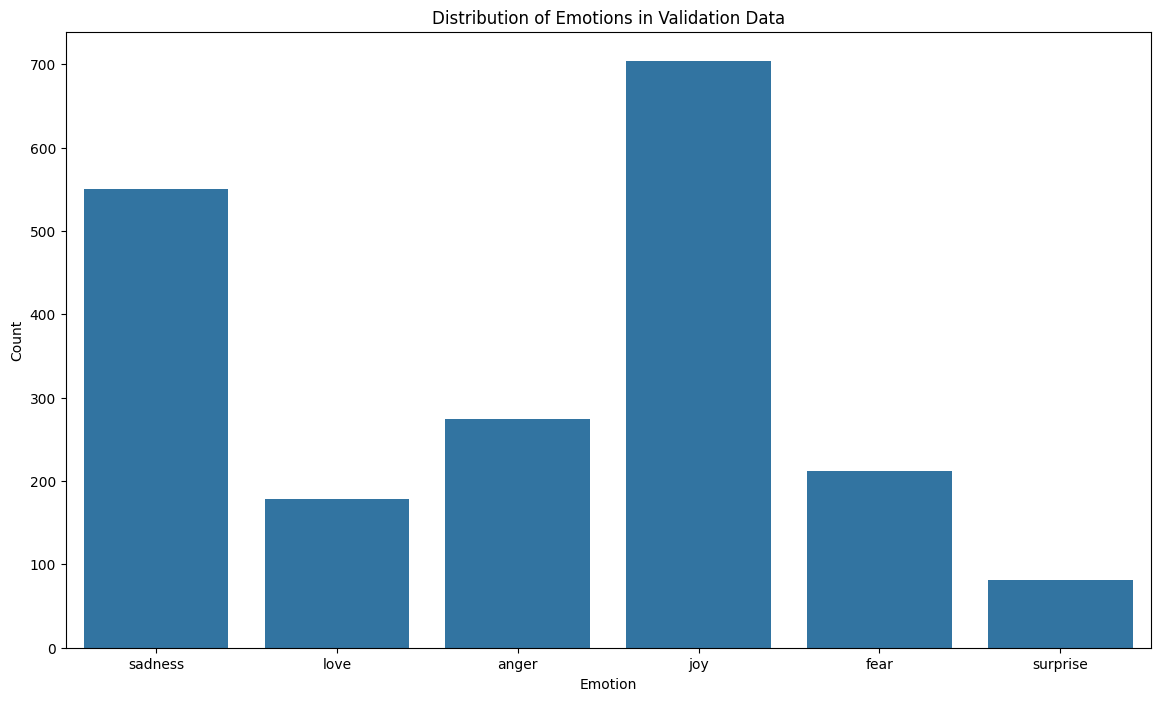

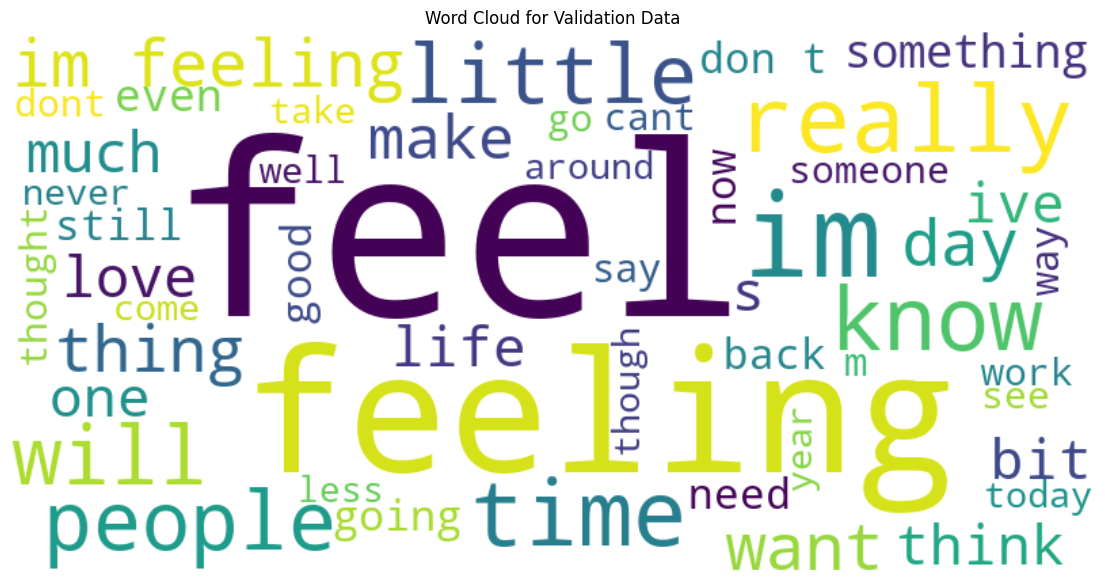

In [15]:
# Function to process and visualize each DataFrame
def process_and_visualize(df, title):
    # Visualize the distribution of emotions
    plt.figure(figsize=(14, 8))
    sns.countplot(x='emotion', data=df)
    plt.title(f'Distribution of Emotions in {title}')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()

    # Generate word cloud
    all_text = ' '.join(df['text'])
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        colormap='viridis', 
        max_words=50
    ).generate(all_text)

    plt.figure(figsize=(14, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {title}')
    plt.show()

    # Processing text
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        words = text.split()
        words = [word for word in words if word not in stop_words]
        words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(words)

    df['clean_text'] = df['text'].apply(clean_text)

    return df



# Process and visualize each DataFrame
train_df = process_and_visualize(train_df, 'Train Data')
print('################################################################')
print('################################################################')
test_df = process_and_visualize(test_df, 'Test Data')
print('################################################################')
print('################################################################')
val_df = process_and_visualize(val_df, 'Validation Data')

In [16]:
X_train = train_df['clean_text']
y_train = train_df['emotion']

X_test = test_df['clean_text']
y_test = test_df['emotion']

X_val = val_df['clean_text']
y_val = val_df['emotion']

In [17]:
label = LabelEncoder()

In [18]:
label.fit(y_train)

y_train = label.transform(y_train)
y_test = label.transform(y_test)
y_val = label.transform(y_val)

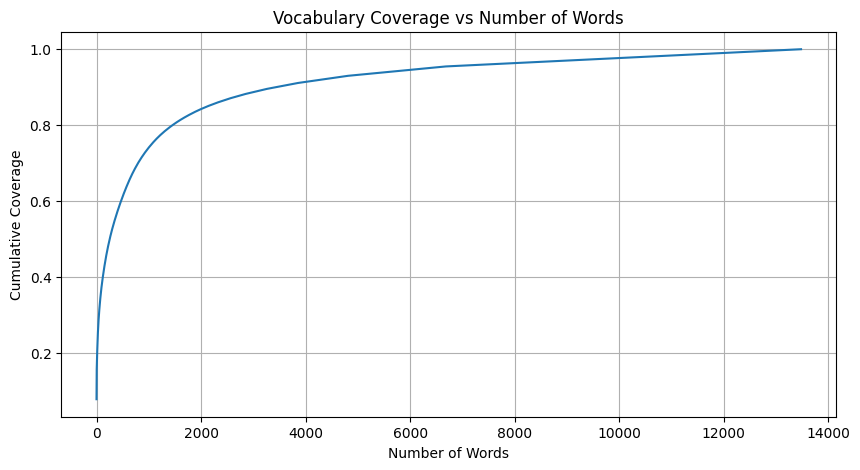

In [19]:
full_tokenizer = Tokenizer(oov_token='<OOV>')
full_tokenizer.fit_on_texts(X_train)

word_counts = sorted(full_tokenizer.word_counts.values(), reverse=True)
cumulative_coverage = np.cumsum(word_counts) / sum(word_counts)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_coverage)
plt.xlabel("Number of Words")
plt.ylabel("Cumulative Coverage")
plt.title("Vocabulary Coverage vs Number of Words")
plt.grid()
plt.show()

In [20]:
vocab_size = next(i for i, c in enumerate(cumulative_coverage) if c >= 0.95)
print(f"Vocabulary size for 95% coverage: {vocab_size}")

Vocabulary size for 95% coverage: 6317


In [21]:
max_vocab_size = 8126

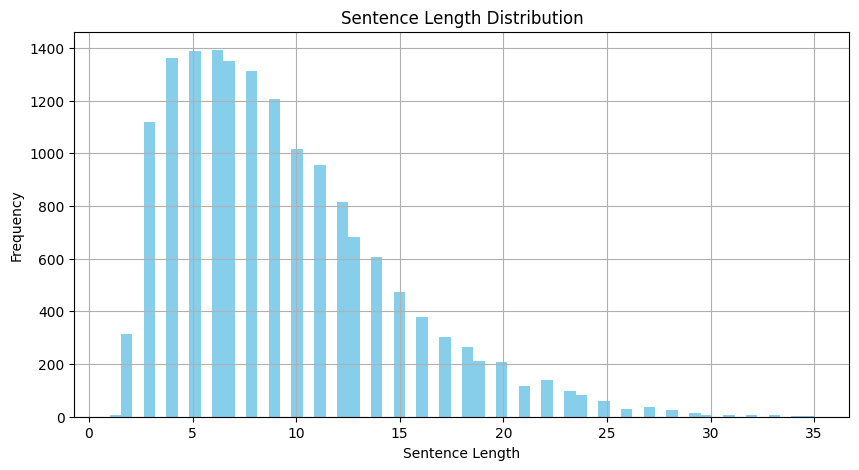

In [22]:
sentence_lengths = [len(sentence.split()) for sentence in X_train]

plt.figure(figsize=(10, 5))
plt.hist(sentence_lengths, bins='auto', color='skyblue')
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("Sentence Length Distribution")
plt.grid()
plt.show()

In [23]:
max_length = np.percentile(sentence_lengths, 100)
print(f"Max sequence length for 100% coverage: {int(max_length)}")

Max sequence length for 100% coverage: 35


In [24]:
max_sequence_length = 35

In [25]:
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding='post')

In [26]:
with open('../models/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

with open('../models/label.pkl', 'wb') as file:
    pickle.dump(label, file)

In [27]:
num_classes = len(np.unique(y_train))

In [28]:
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)
y_val_categorical = to_categorical(y_val, num_classes=num_classes)

# Model Architecture - LSTM

In [35]:
model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_sequence_length),
    Flatten(),
    Dense(64, activation='relu'),
    # Dropout(0.5),
    Dense(32, activation='relu'),
    # Dropout(0.5),
    Dense(6, activation='softmax')
])

/Users/mohamedaminemrabet/miniforge3/envs/tfnew/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
history = model.fit(
    X_train_padded, y_train_categorical,
    validation_data=(X_val_padded, y_val_categorical),
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4316 - loss: 1.4482 - val_accuracy: 0.7435 - val_loss: 0.7346
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8534 - loss: 0.4514 - val_accuracy: 0.8720 - val_loss: 0.3891
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9647 - loss: 0.1110 - val_accuracy: 0.8715 - val_loss: 0.4127
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9863 - loss: 0.0448 - val_accuracy: 0.8670 - val_loss: 0.4545
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9927 - loss: 0.0282 - val_accuracy: 0.8685 - val_loss: 0.4748


In [39]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (32, 35, 128)          │     1,040,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 4480)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 64)               │       286,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 32)               │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 6)                │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,987,572 (15.21 MB)

 Trainable params: 1,329,190 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,658,382 (10.14 MB)

In [40]:
model.save('../models/model-Fully_conected_NN.h5')

# Eval

In [41]:
loss, accuracy = model.evaluate(X_test_padded, y_test_categorical)
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Loss: {loss:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.8752 - loss: 0.4770
Test Accuracy: 0.87
Test Loss: 0.47


In [42]:
y_pred_prob = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert true labels to numerical format (assuming you have a label encoder)
y_test_num = y_test

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [43]:
print(classification_report(y_test_num, y_pred, target_names=label.classes_))

              precision    recall  f1-score   support

       anger       0.86      0.85      0.86       275
        fear       0.84      0.83      0.84       224
         joy       0.90      0.92      0.91       695
        love       0.76      0.77      0.77       159
     sadness       0.91      0.90      0.91       581
    surprise       0.64      0.68      0.66        66

    accuracy                           0.87      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.87      0.87      0.87      2000



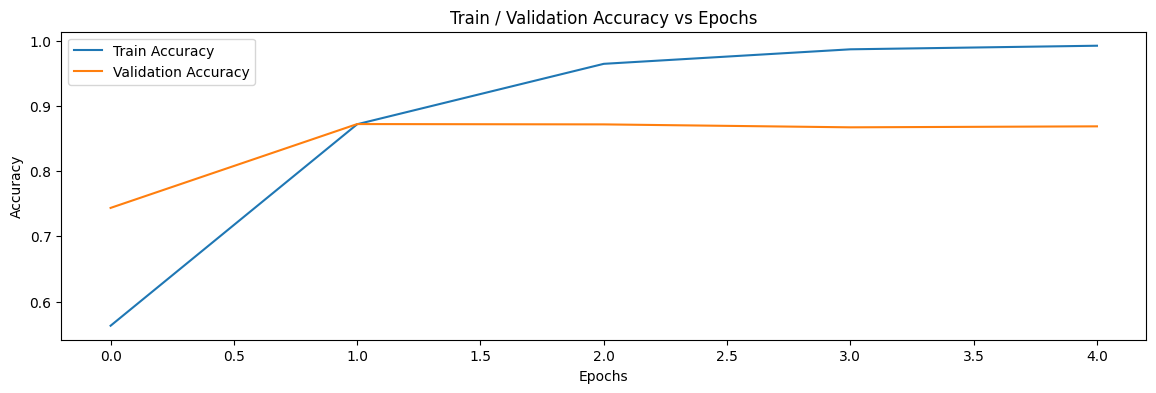

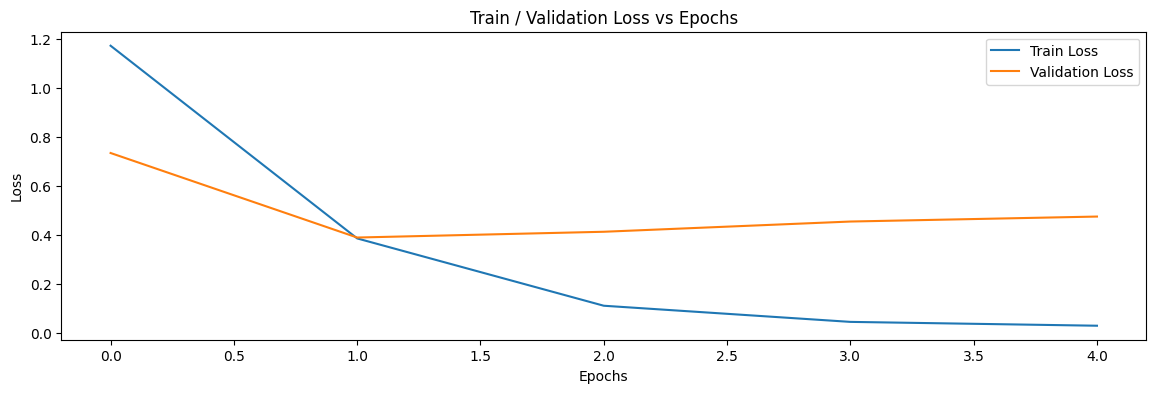

In [44]:
plt.figure(figsize=(14, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train / Validation Accuracy vs Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(14, 4))
plt.title('Train / Validation Loss vs Epochs')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Inference

In [45]:
def predict_emotion(text):
    text_cleaned = clean_text(text)
    
    text_seq = tokenizer.texts_to_sequences([text_cleaned])
    
    text_padded = pad_sequences(text_seq, maxlen=max_sequence_length, padding='post')
    
    prediction = model.predict(text_padded)
    predicted_class = np.argmax(prediction, axis=1)[0]
    
    emotion_label = label.inverse_transform([predicted_class])[0]
    
    return emotion_label

In [46]:
input_text = "i dont know i feel so lost"

predicted_emotion = predict_emotion(input_text)
print(f"The emotion of the text is: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The emotion of the text is: sadness


Lets take this example from the test data `i wasnt feeling sociable i really wasnt;joy`

In [47]:
input_text = "i wasnt feeling sociable i really wasnt"

predicted_emotion = predict_emotion(input_text)
print(f"The emotion of the text is: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The emotion of the text is: joy
